# Linear BMM with SAMBA toy models

This notebook shows how to use the Bayesian model mixing package **Taweret** for a toy problem. 

Author : Dan Liyanage 

Date : 19/21/2022

## Steps for linear BMM
    1. Get Models with a prediction method
    2. Choose a Mixing method 
    3. Estimate the mixture weights (parameters in the mixture function) with user defined calibration method
To execute each step in this notebook we need to import the following from Taweret.

In [1]:
import sys
import os
import corner
sys.path.insert(0, os.path.abspath('../../../../Taweret'))

import matplotlib as mpl
import emcee
mpl.rcParams['figure.facecolor'] = 'white'


In [2]:
# Import models with a predict method
from Taweret.models import samba_models as toy_models
# Mixing object with a likelihood method
from Taweret.mix.linear import linear_mix as LM
# Wrapper for the likelihood to be used with Bilby
from Taweret.calibrate.likelihood_wrappers import likelihood_wrapper_for_bilby 

ModuleNotFoundError: No module named 'Taweret.calibrate'

In [ ]:
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For calibration
import bilby

# For other operations
import numpy as np
import os
import shutil

In [ ]:
m1 = toy_models.loworder(2, 'uninformative')
m2 = toy_models.highorder(2, 'uninformative')
truth = toy_models.true_model()
exp = toy_models.exp_data()

In [ ]:
g = np.linspace(0.1, 0.6, 10)
plot_g = np.linspace(0.01,1,100)
m1_prediction = m1.predict(plot_g)
m2_prediction = m2.predict(plot_g)
true_output = truth.predict(plot_g)
exp_data= exp.predict(g,error = 0.01)

In [ ]:
exp_data

(array([2.45684038, 2.35047097, 2.30632708, 2.20925286, 2.16321254,
        2.06277361, 1.96542988, 1.95347058, 1.89289515, 1.79399826]),
 array([0.0245684 , 0.02350471, 0.02306327, 0.02209253, 0.02163213,
        0.02062774, 0.0196543 , 0.01953471, 0.01892895, 0.01793998]))

# 1. The models and the experimental data.

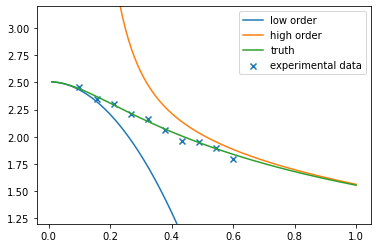

In [ ]:
fig, ax_f = plt.subplots()
ax_f.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax_f.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax_f.plot(plot_g, true_output[0], label='truth')
ax_f.scatter(g,exp_data[0], marker='x', label='experimental data')
ax_f.set_ylim(1.2,3.2)
ax_f.legend()

#  2. Choose a Mixing method

In [ ]:
mix_model = LM(m1, m2, g, exp_data[0], exp_data[1], method='cdf', n_mix=2)

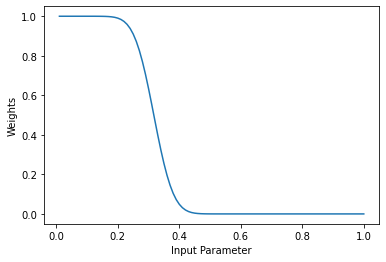

In [ ]:
mix_model.plot_weights(np.array([6.33829194, -19.99152447]),plot_g)

In [ ]:
#mix_model.mix_loglikelihood_test(np.array([6.33829194, -19.99152447]))

In [ ]:
mix_model.mix_loglikelihood(np.array([6.33829194, -19.99152447]))

5.284401238135784

### BMM model output corresponding to the above input weights 

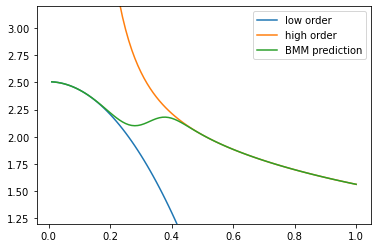

In [ ]:
fig, ax = plt.subplots()
mix_prediction = mix_model.prediction(np.array([6.33829194, -19.99152447]),plot_g)
ax.plot(plot_g, m1_prediction[0].flatten(), label='low order')
ax.plot(plot_g, m2_prediction[0].flatten(), label='high order')
ax.plot(plot_g, mix_prediction.flatten(), label='BMM prediction')
ax.set_ylim(1.2,3.2)
ax.legend()

In [13]:
design_min = [-20,-20]
design_max = [20, 20]
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

In [16]:
# Covariance truncation error from PC is not yet included
def log_posterior(model_parameters):
    #only_diagonal=np.diag(total_var.diagonal())
    return log_prior(model_parameters) + mix_model.mix_loglikelihood(model_parameters)

In [17]:
#set starting points per parameter
import pandas as pd
nwalkers=20
ndim=2
nburn=200
nsteps=3000
nthin=5

starting_points = np.zeros((nwalkers, ndim))
starting_points[:,0] = np.random.uniform(0.1, 10, nwalkers)
starting_points[:,1] = np.random.uniform(0.2, 3, nwalkers)

sampler_mixed = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
print('burn in sampling started')
for p, lnprob, lnlike in sampler_mixed.sample(starting_points, iterations=nburn):
    pass
sampler_mixed.reset() # Discard previous samples from the chain, but keep the position
print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(np.mean(sampler_mixed.acceptance_fraction),nwalkers*nburn))
print('Burn in completed. Now running the samples')
for p, lnprob, lnlike in sampler_mixed.sample(p, iterations=nsteps, thin=nthin):
    pass
print('Done MCMC')
print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(np.mean(sampler_mixed.acceptance_fraction),nwalkers*nsteps))
samples = sampler_mixed.chain.reshape((-1, ndim))
samples_df=pd.DataFrame(samples, columns=['theta_0', 'theta_1'])


burn in sampling started


/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/emcee/ensemble.py:542: RuntimeWarning: invalid value encountered in true_divide
  return self.backend.accepted / float(self.backend.iteration)


Mean acceptance fraction: nan (in total 4000 steps)
Burn in completed. Now running the samples
Done MCMC
Mean acceptance fraction: 0.686 (in total 60000 steps)


In [18]:
samples_df

,theta_0,theta_1
0,3.489142,-11.100323
1,3.402739,-10.470403
2,4.888684,-16.093546
3,5.417555,-15.141035
4,5.074758,-13.585939
...,...,...
11995,3.803397,-10.614420
11996,4.387487,-11.333776
11997,3.921957,-9.540634
11998,3.843481,-8.993512


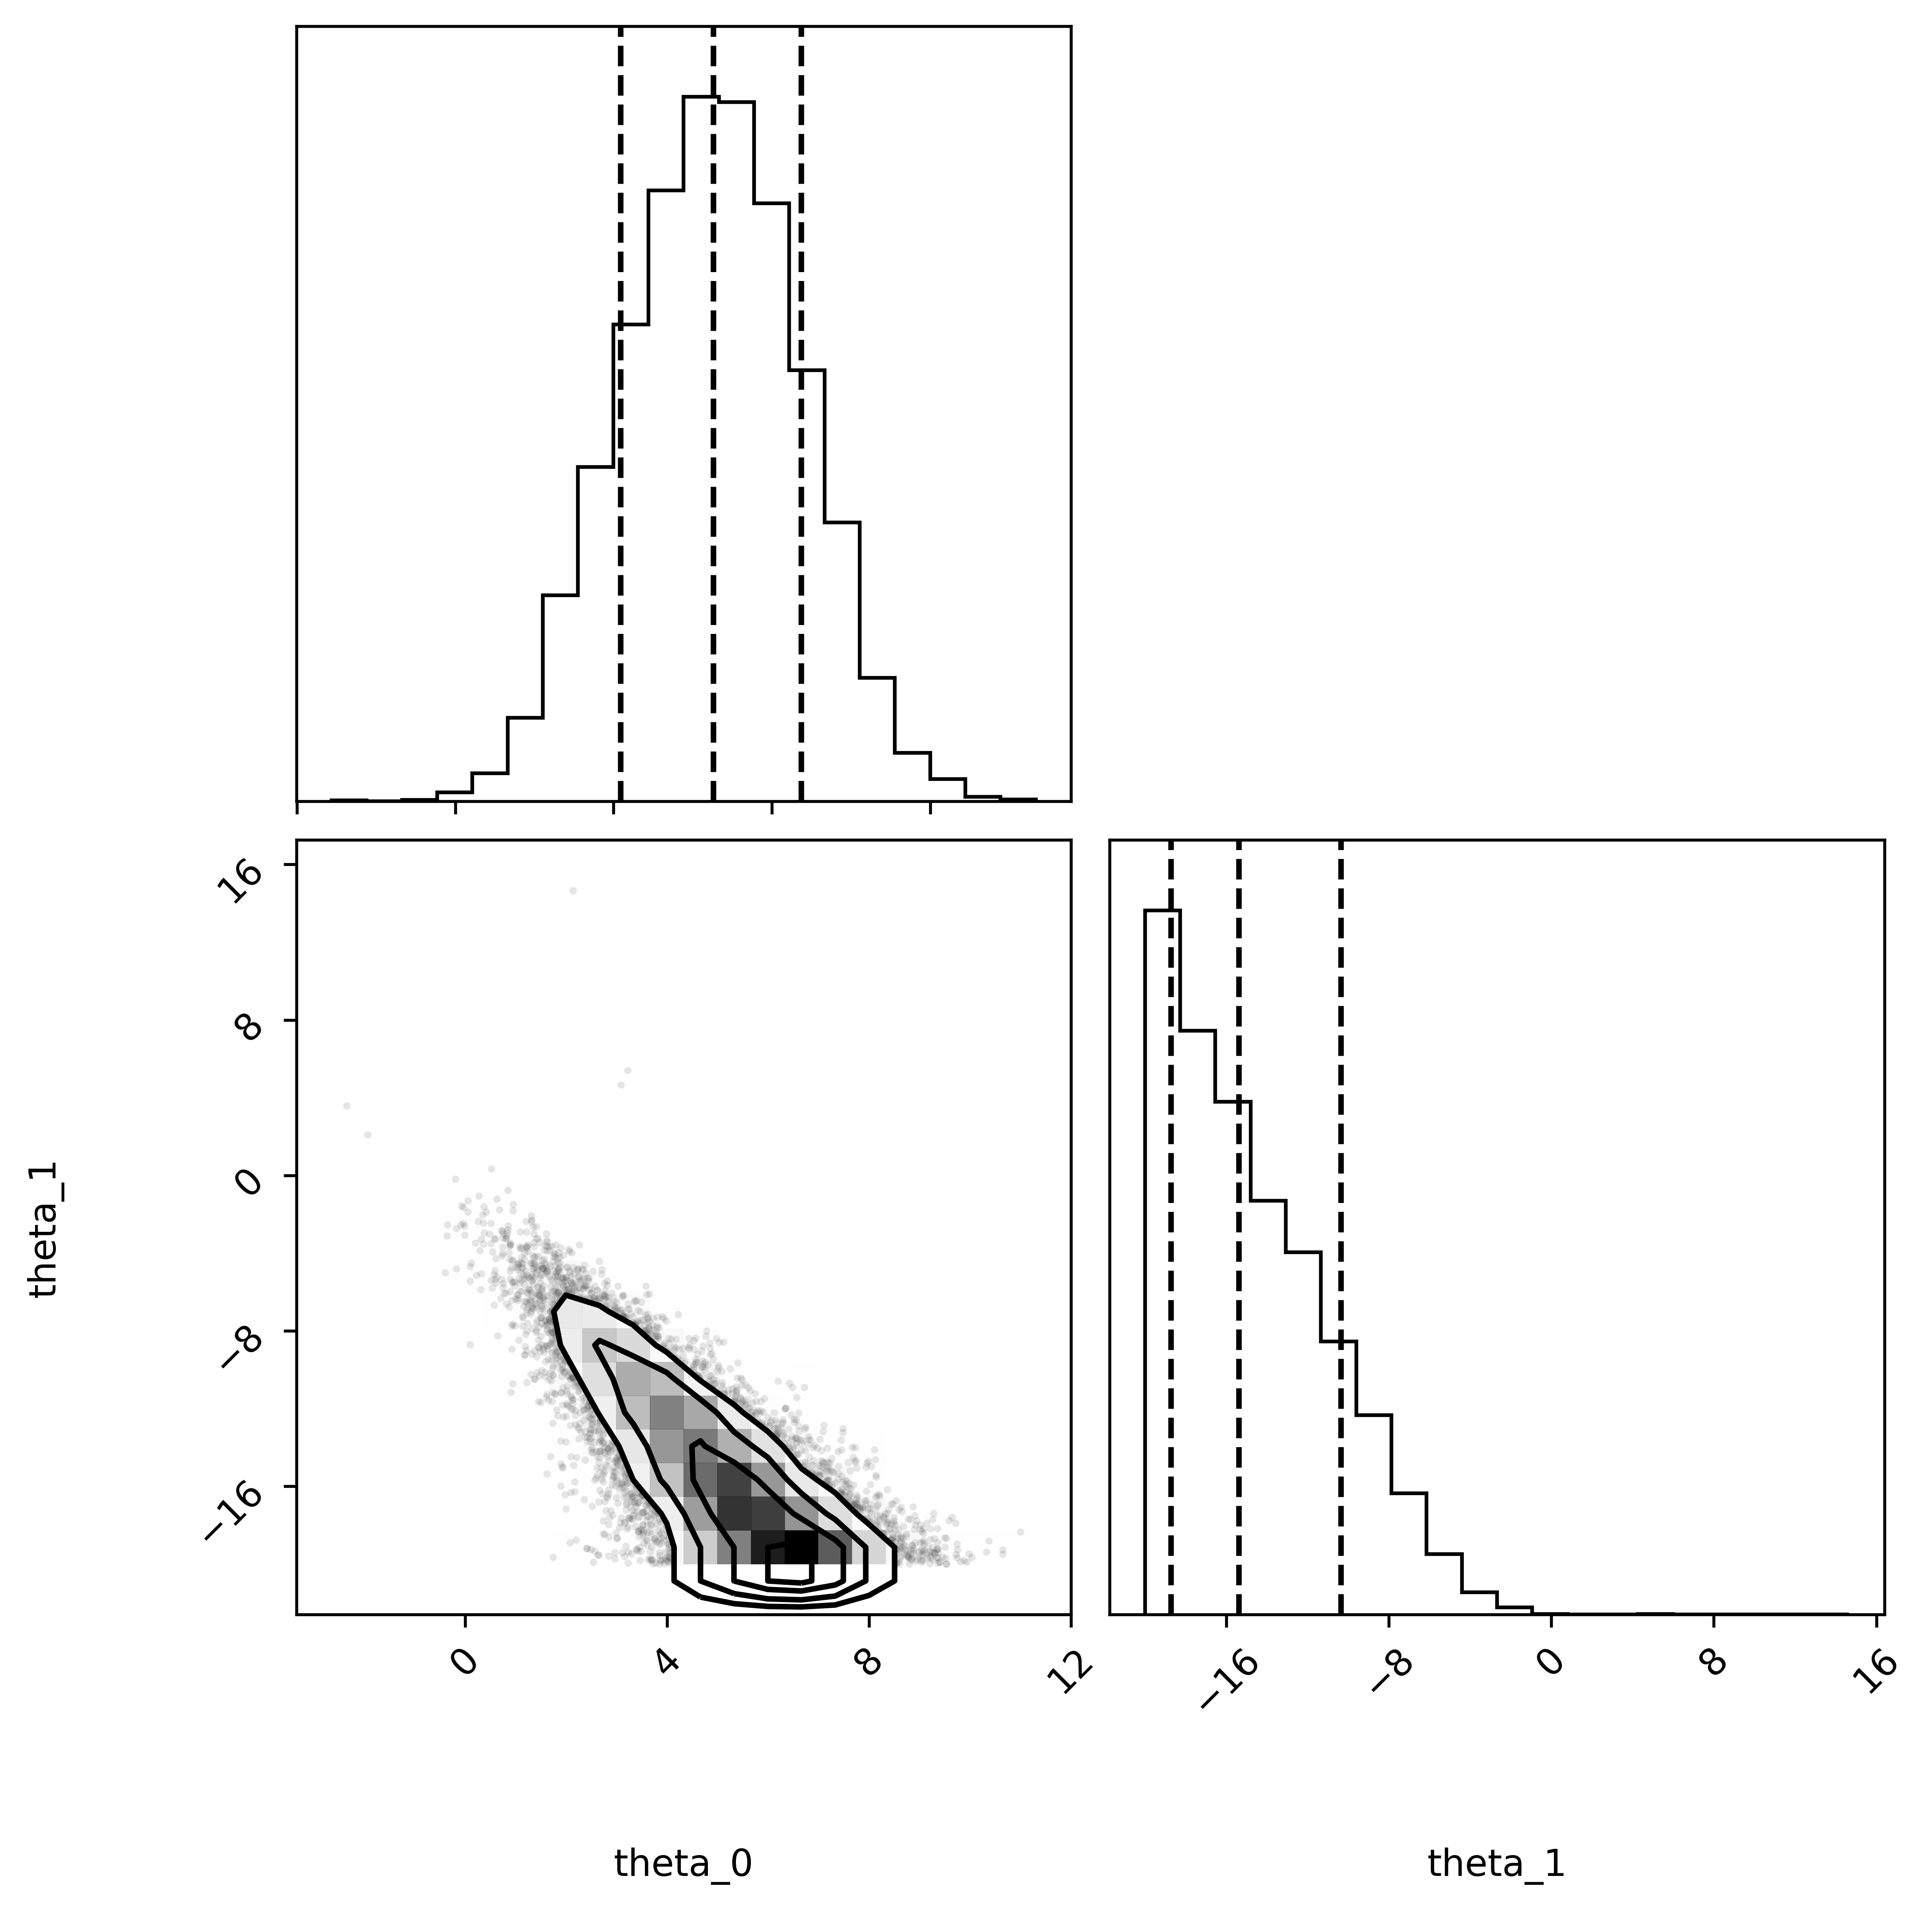

In [19]:
#corner plots
fig, axs = plt.subplots(2,2, figsize=(8,8), dpi=600)
corner.corner(samples_df,labels=samples_df.columns[0:2],quantiles=[0.16, 0.5, 0.84],fig=fig)
plt.show()

# 3. Estimating the mixture weights

### Wrap the likelihood function in the mixed model to be calibrated

In [20]:
likelihood = likelihood_wrapper_for_bilby(mix_model)

### Get posterior samples using Bilby

Need to speceify a constained prior for switchcos. g1 < g3 < g2
We follow Bilby documentation on how to specefy a prior with constraints
https://lscsoft.docs.ligo.org/bilby/prior.html#prior-constraints

19:37 bilby INFO    : Running for label 'samba_cdf', output will be saved to 'outdir'
19:37 bilby INFO    : Search parameters:
19:37 bilby INFO    :   theta_0 = Uniform(minimum=-20, maximum=20, name='theta_0', latex_label='theta_0', unit=None, boundary=None)
19:37 bilby INFO    :   theta_1 = Uniform(minimum=-20, maximum=20, name='theta_0', latex_label='theta_0', unit=None, boundary=None)
19:37 bilby INFO    : Single likelihood evaluation took 2.216e-04 s
19:37 bilby WARNING : The 'threads' argument cannot be used for parallelisation. This run will proceed without parallelisation, but consider the use of an appropriate Pool object passed to the 'pool' keyword.
19:37 bilby WARNING : Supplied argument 'npool' not an argument of 'Emcee', removing.
19:37 bilby WARNING : Supplied argument 'threads' not an argument of 'Emcee', removing.
19:37 bilby INFO    : Using sampler Emcee with kwargs {'nwalkers': 20, 'a': 2, 'args': [], 'kwargs': {}, 'postargs': None, 'pool': None, 'live_dangerously': F

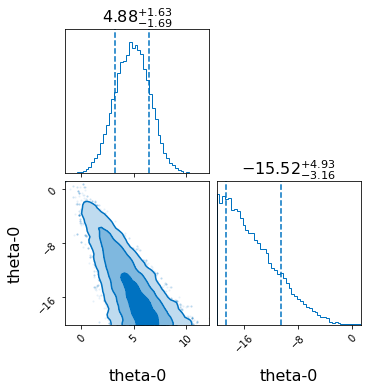

In [24]:
# A few simple setup steps
label = "samba_cdf"
outdir = "outdir"

priors = dict(
   theta_0=bilby.core.prior.Uniform(-20,20, "theta_0"),
   theta_1=bilby.core.prior.Uniform(-20,20, "theta_0")
)

# priors = dict(
#     theta_0=bilby.core.prior.Beta(2,2)
# )

# And run sampler
## If file exists, delete it ##
if os.path.exists(f'{outdir}/{label}_result.json'):
    os.remove(f'{outdir}/{label}_result.json')
    os.remove(f'{outdir}/{label}_checkpoint_resume.pickle')
    os.remove(f'{outdir}/{label}_samples.txt')
    #shutil.rmtree(outdir)
result = bilby.run_sampler(
    likelihood,
    priors,
    label=label,
    outdir=outdir,
    sampler="emcee",
    nwalkers=20,
    nburn=200,
    nsteps=3000,  # This is the number of raw samples
    threads=5,
    )
result.plot_corner()


In [25]:
result.posterior

,theta_0,theta_1,log_likelihood,log_prior
0,1.781561,-5.786210,3.735286,-7.377759
1,1.781561,-5.786210,4.619900,-7.377759
2,1.781561,-5.786210,4.232894,-7.377759
3,1.781561,-5.786210,4.219245,-7.377759
4,2.572512,-8.951114,4.917470,-7.377759
...,...,...,...,...
55995,7.026066,-19.150620,4.171079,-7.377759
55996,7.026066,-19.150620,4.889525,-7.377759
55997,7.026066,-19.150620,4.050403,-7.377759
55998,6.750586,-18.976678,3.644891,-7.377759


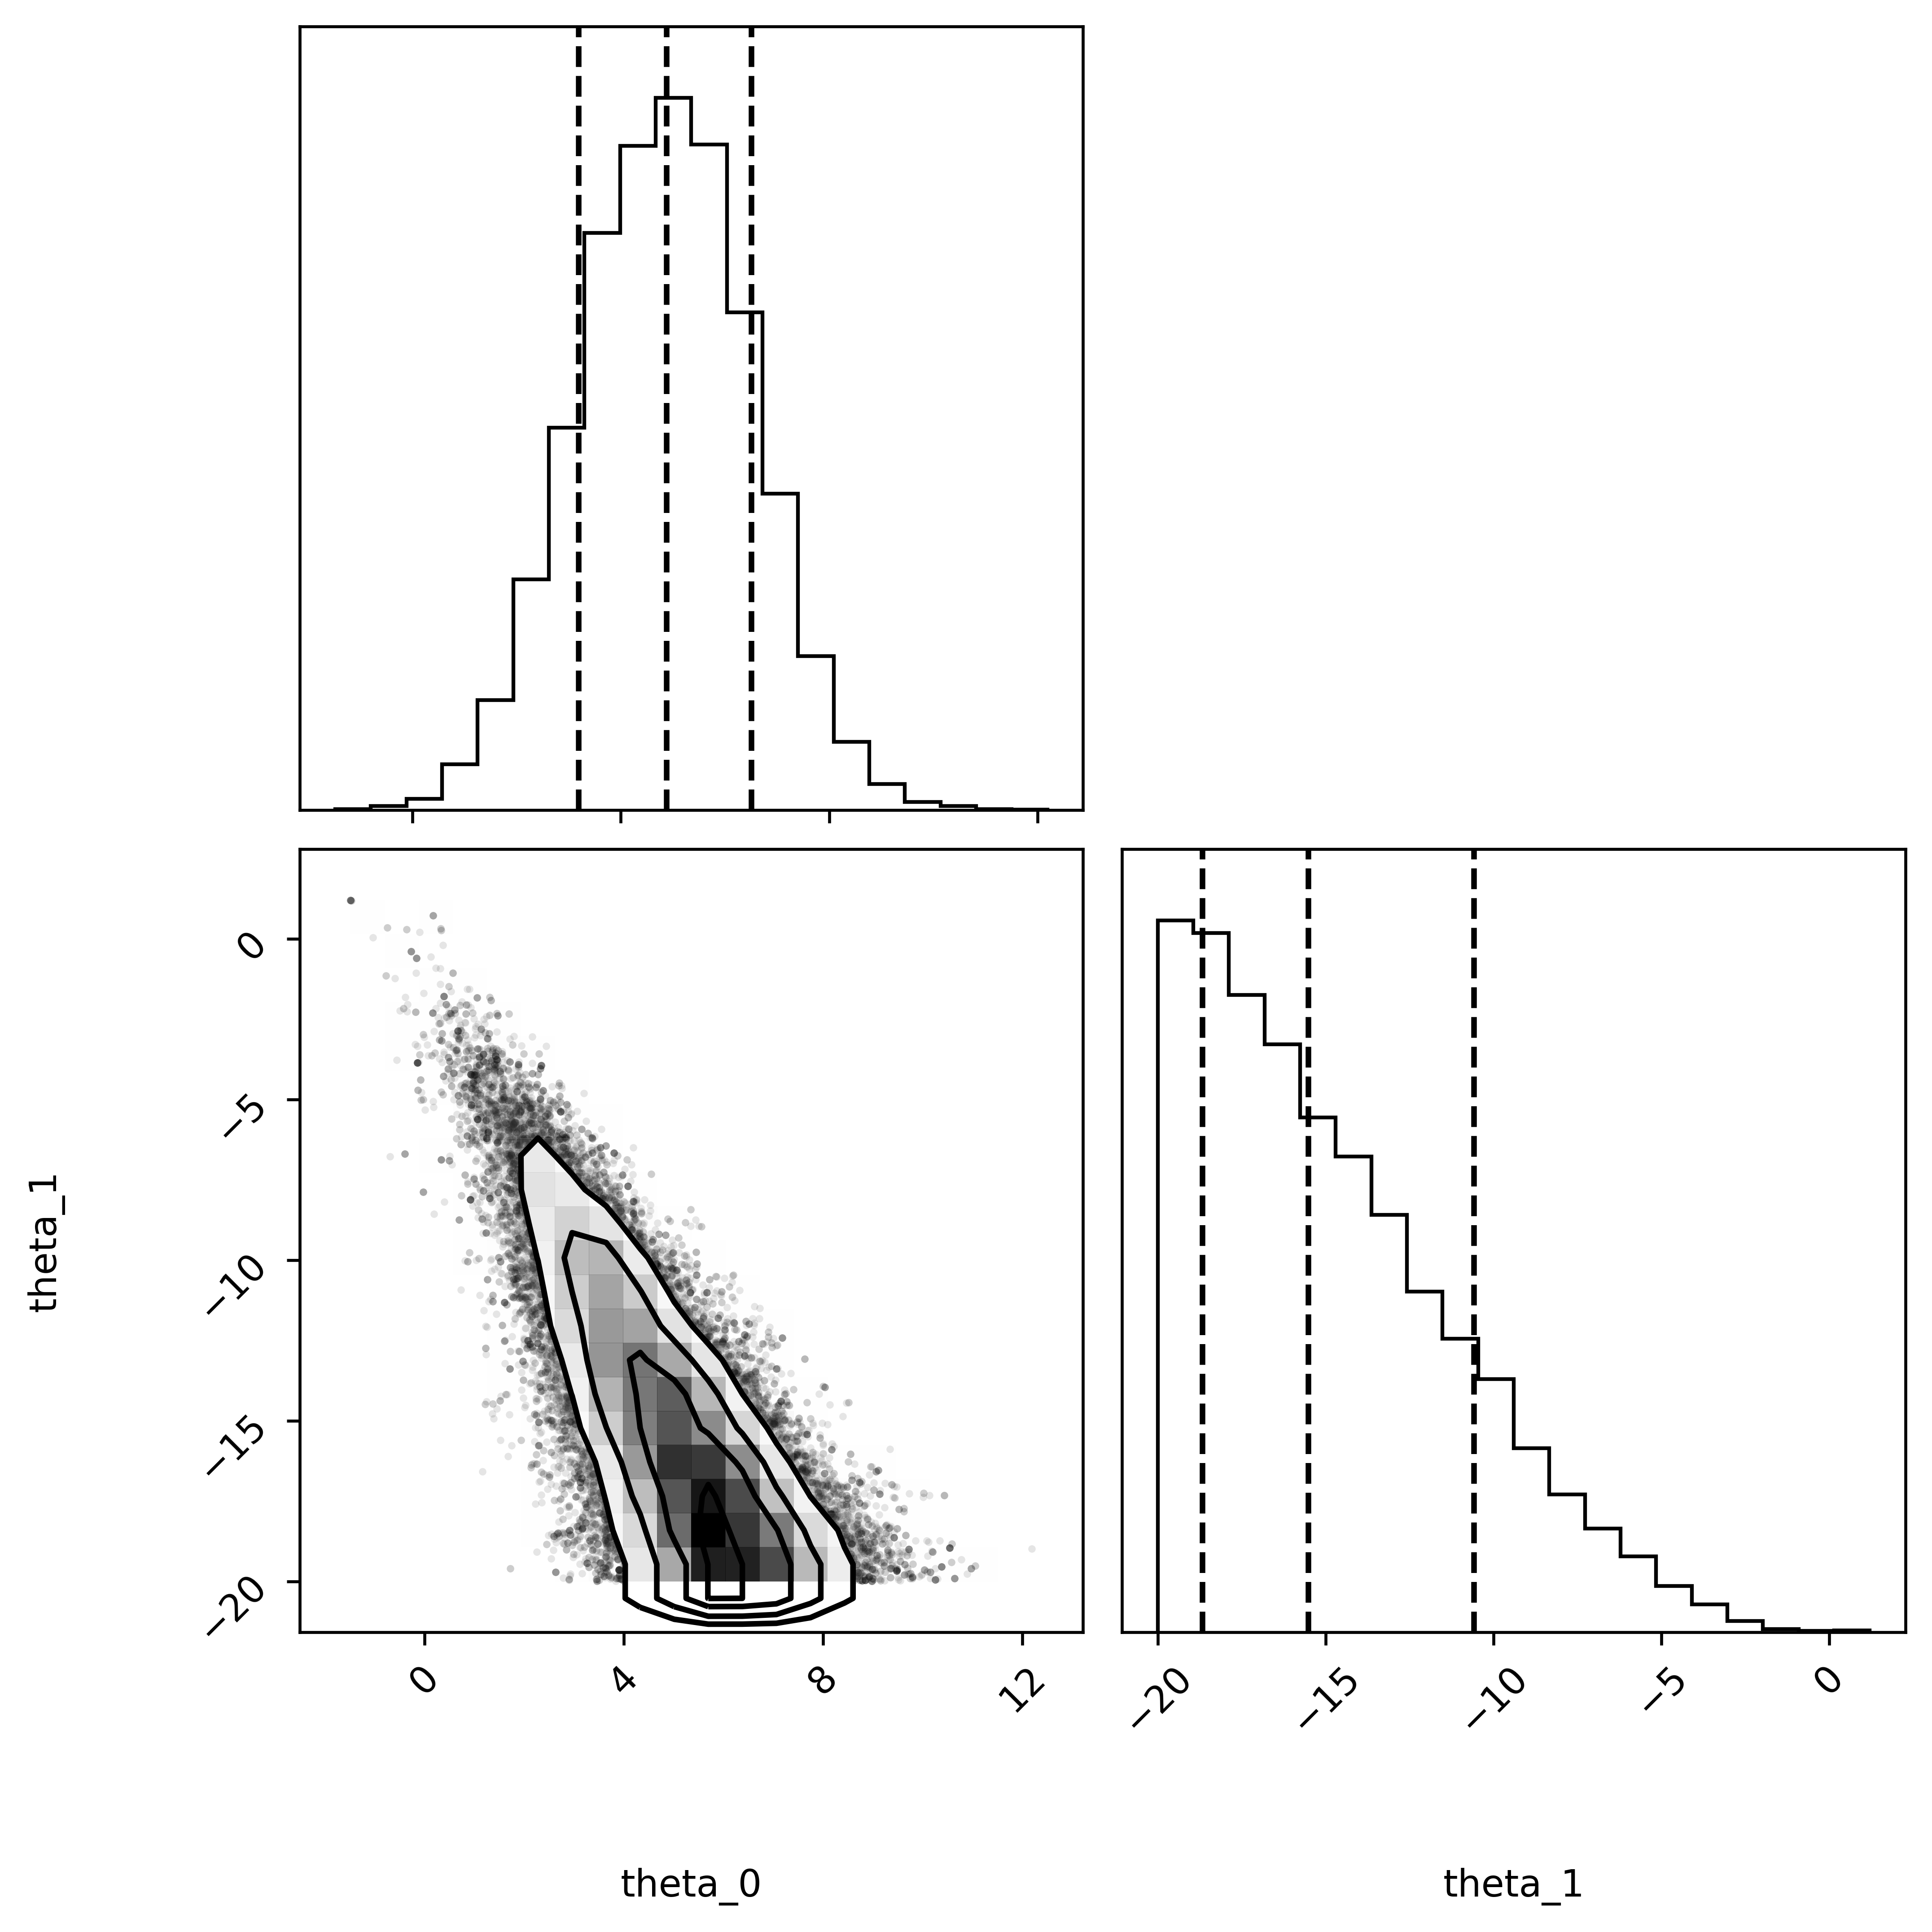

In [26]:
#corner plots
fig, axs = plt.subplots(2,2, figsize=(8,8), dpi=600)
corner.corner(result.posterior.values[:,0:2],labels=result.posterior.columns[0:2],quantiles=[0.16, 0.5, 0.84],fig=fig)
plt.show()

In [ ]:
#mix_model.mix_loglikelihood(np.array([0.2, 0.4, 0.3]))

In [ ]:
mix_model.mix_loglikelihood(result.posterior.values[0,0:2])

In [ ]:
result.posterior['log_likelihood'].values

In [ ]:
n_max = np.argmax(result.posterior['log_likelihood'].values)
print(n_max)
print(result.posterior.values[n_max,2])

In [ ]:
MAP_value = result.posterior.values[n_max,0:2]
print(MAP_value)
print()

In [ ]:
# If false, do not try to find the MAP value and load it from a saved file.
find_map_param = True
from scipy import optimize
if find_map_param == True:
    bounds=[(a,b) for (a,b) in zip([0,0,0],[1,1,1])]
    print(bounds)
    x0 = [a+b/2 for a,b in bounds]
    rslt = optimize.differential_evolution(lambda x: -mix_model.mix_loglikelihood(x) if x[0]<x[2] and x[1]>x[2] else 1000,
                                           bounds=bounds,
                                          maxiter=100000,
                                           tol=1e-15,
                                           disp=True)
    # minimizer_kwargs = {"method": "L-BFGS-B", "bounds": bounds,"tol":1e-15}
    # rslt=optimize.basinhopping(lambda x: -mix_model.mix_loglikelihood(x) if x[0]<x[2] and x[1]>x[2] else 1000
    #                             ,x0,niter=1000,minimizer_kwargs=minimizer_kwargs)
    map_values = rslt.x
    np.save(f'{outdir}/{label}', map_values)
else:
    map_values = np.load(f'{outdir}/{label}'+'.npy')
print(map_values)

### trace plots

In [ ]:

#sns.set_context(font_scale=100)
fig, ax = plt.subplots(figsize=(50,10))
ax.plot(result.posterior['theta_0'].values)

In [ ]:
pos_weight_func = []
for sample in result.posterior.values[:,0:2]:
    mean = mix_model.weights(np.array([sample]).flatten(), plot_g)
    pos_weight_func.append(mean)
pos_weight_func = np.array(pos_weight_func).reshape(-1,len(plot_g))

In [ ]:
per0,per5,per20,per80,per95,per100=np.percentile(pos_weight_func,[0,5,20,80,95,100], axis=0)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.fill_between(plot_g,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.legend()
#ax.plot(plot_g, true_output[0], label='truth')
#ax.set_ylim(1.2,3.2)

### Predictions for the mixed model with posterior weights

In [ ]:
pos_predictions = []
for sample in result.posterior.values[:,0:2]:
    mean = mix_model.prediction(np.array([sample]).flatten(),plot_g)
    pos_predictions.append(mean)
pos_predictions = np.array(pos_predictions).reshape(-1,len(plot_g))

In [ ]:
pos_predictions.shape

In [ ]:
per0,per5,per20,per80,per95,per100=np.percentile(pos_predictions,[0,5,20,80,95,100], axis=0)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.fill_between(plot_g,per5,per95,color=sns.color_palette()[4], alpha=0.2, label='90% C.I.')
ax.fill_between(plot_g,per20,per80, color=sns.color_palette()[4], alpha=0.3, label='60% C.I.')
ax.plot(plot_g, true_output[0], label='truth')
ax.legend()
ax.set_ylim(1.2,3.2)